# Capital Asset Pricing Model (CAPM)

CAPM helps identify systematic risk, In summary:
$$ E[r_a] = r_f + \beta_a(E[r_m] - r_f)$$
$$ \beta_a = \frac{Cov(r_a,r_m)}{Var(r_m)}$$

In [57]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns

In [61]:
sns.set_style('darkgrid')

## Get Data

In [21]:
def get_data(stock, start, end):
    
    key = '*'
    
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock}&apikey={key}&outputsize=full"
    
    r = requests.get(url)
    r.raise_for_status()
    
    df = pd.DataFrame.from_dict(
        r.json()['Time Series (Daily)'], orient='index'
    )
    
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    df['5. adjusted close'] = df['5. adjusted close'].astype('float')
    
    return df[start:end]['5. adjusted close']

Inputs

In [31]:
stock = 'IBM'
market = 'SPY'

In [13]:
r_f = 0.05

In [14]:
start_date = '2010-01-01'
end_date = '2017-01-01'

Grab and clean the data

In [32]:
s = get_data(stock, start_date, end_date)
m = get_data(market, start_date, end_date)

In [33]:
s = s.resample('M').last()
m = m.resample('M').last()

In [34]:
data = pd.concat([s,m], axis=1)
data.columns = ['stock', 'market']

In [38]:
data.head()

,stock,market
2010-01-31,87.8536,86.9851
2010-02-28,91.6895,89.6986
2010-03-31,92.4755,95.1617
2010-04-30,93.0163,96.6339
2010-05-31,90.7933,88.9559


Calculate the log monthly returns

In [45]:
m_returns = np.log(data/data.shift(1)).dropna()

## CAPM

In [51]:
beta = m_returns.cov().loc['stock', 'market']/m_returns.cov().loc['market', 'market']

As the beta is less than 1, it is less volatile than the market

In [52]:
beta

0.7159060556551758

You can also calculate the beta using a linear regression between the market and stock return

In [56]:
beta, alpha = np.polyfit(m_returns['market'],m_returns['stock'], deg=1)
beta, alpha

(0.715906055655176, -0.0018959836655829286)

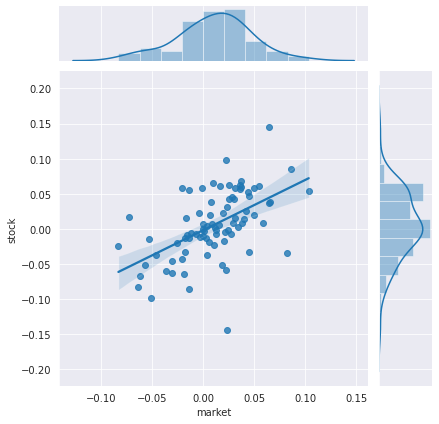

In [62]:
sns.jointplot(m_returns['market'],m_returns['stock'], kind='reg')

In [72]:
r_m = data['market'].pct_change().dropna().mean()*12
expected_return = r_f + beta*(r_m - r_f)
f"{round(expected_return*100,2)}%"

'11.1%'

## END